## GAN on MNIST

https://towardsdatascience.com/gan-by-example-using-keras-on-tensorflow-backend-1a6d515a60d0

https://github.com/PacktPublishing/Advanced-Deep-Learning-with-Keras/blob/master/chapter4-gan/dcgan-mnist-4.2.1.py

https://github.com/eriklindernoren/Keras-GAN/blob/master/gan/gan.py

https://github.com/keras-team/keras/issues/8585

https://github.com/soumith/ganhacks

In [1]:
import warnings
warnings.simplefilter('ignore')

In [98]:
import keras
import numpy as np
import datetime
import tensorflow as tf
import matplotlib.pyplot as plt

from keras.models import Sequential, Model, Input
from keras.layers import Dense, BatchNormalization, Activation, LeakyReLU, Dropout, \
                                Reshape, UpSampling2D, Conv2DTranspose, Flatten, \
                                Conv2D, Convolution2D, GaussianNoise
from keras.optimizers import Adam
from keras.datasets import mnist, fashion_mnist, cifar10
from keras.callbacks import TensorBoard
from keras.layers.merge import _Merge
from keras.models import load_model
import keras.backend as K

from tqdm import tqdm_notebook
from collections import namedtuple
from functools import partial

%matplotlib inline

In [99]:
K.image_data_format(), K.backend()

('channels_last', 'tensorflow')

In [100]:
# K.tensorflow_backend._get_available_gpus()

In [111]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
h, w, c = (28, 28, 1)
X_train.shape

(60000, 28, 28)

In [110]:
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
h, w, c = (28, 28, 1)
X_train.shape

(60000, 28, 28)

In [109]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
h, w, c = (32, 32, 3)
X_train.shape

(50000, 32, 32, 3)

In [104]:
# X_train = np.vstack((X_train, X_test))
# y_train = np.hstack((y_train, y_test))

In [112]:
channels_first = K.image_data_format() == 'channels_first'
channels_first

False

In [113]:
x0, x1, x2 = X_train.shape

if channels_first:
    X_train = X_train.reshape((x0, 1, x1, x2))
else:
    X_train = X_train.reshape((x0, x1, x2, 1))
    
def scale(a):
    """-1 to 1 for tanh"""
    return (2 * (a - a.min()) / (a.max() - a.min())) - 1

def reverse_scale(a):
    return 255 * (a - a.min()) / (a.max() - a.min())
    
X_train = scale(X_train)

In [114]:
X_train = X_train[y_train==2]

In [39]:
def add_lr_flips(x):
    flip_lr = np.flip(x, axis=2)
    return np.vstack((x, flip_lr))

X_train = add_lr_flips(X_train)

In [115]:
X_train.shape

(5958, 28, 28, 1)

In [116]:
GRADIENT_PENALTY_WEIGHT = 10
BATCH_SIZE = 64
N_BATCHES = int(X_train.shape[0] / BATCH_SIZE)
N_BATCHES

93

In [117]:
depth = 64
dim = 7
units = dim * dim * depth

if channels_first:
    reshape_output_shape = (depth, dim, dim)
    bn_axis = 1
    conv2d_input_shape = (c, h, w)
else:
    reshape_output_shape = (dim, dim, depth)
    bn_axis = -1
    conv2d_input_shape = (h, w, c)
    
def make_generator():
    return Sequential([
        Dense(1024, input_dim=100),
        LeakyReLU(),
        Dense(units),
        BatchNormalization(),
        LeakyReLU(),
        Reshape(reshape_output_shape, input_shape=(units,)),   
        Conv2DTranspose(depth, (5, 5), strides=2, padding='same'),
        BatchNormalization(axis=bn_axis),
        LeakyReLU(),
        Convolution2D(int(depth/2), (5, 5), padding='same'),
        BatchNormalization(axis=bn_axis),
        LeakyReLU(),
        Conv2DTranspose(int(depth/2), (5, 5), strides=2, padding='same'),
        BatchNormalization(axis=bn_axis),
        LeakyReLU(),
        Convolution2D(1, (5, 5), padding='same'),
        Activation('tanh'),
    ])


def make_discriminator():
    return Sequential([
        Convolution2D(64, (5, 5), padding='same', input_shape=conv2d_input_shape),
        LeakyReLU(),
        Convolution2D(128, (5, 5), kernel_initializer='he_normal', strides=[2, 2]),
        LeakyReLU(),
        Convolution2D(128, (5, 5), kernel_initializer='he_normal', padding='same', strides=[2, 2]),
        LeakyReLU(),
        Flatten(),
        Dense(1024, kernel_initializer='he_normal'),
        LeakyReLU(),
        Dense(1, kernel_initializer='he_normal'),
    ])

In [118]:
# different generator

def make_generator():
    std = 0.2
    return Sequential([
        Dense(1024, input_dim=100),
        GaussianNoise(std),
        LeakyReLU(),
        Dense(units),
        BatchNormalization(),
        LeakyReLU(),
        Reshape(reshape_output_shape, input_shape=(units,)),   
        UpSampling2D(),
        Conv2DTranspose(int(depth/2), 5, padding='same'),
        BatchNormalization(momentum=0.9, axis=bn_axis),
        GaussianNoise(std),
        LeakyReLU(alpha=0.2),
        Conv2DTranspose(int(depth/4), 5, padding='same'),
        BatchNormalization(momentum=0.9),
        GaussianNoise(std),
        LeakyReLU(alpha=0.2),
        UpSampling2D(),
        Conv2DTranspose(int(depth/8), 5, padding='same'),
        BatchNormalization(momentum=0.9, axis=bn_axis),
        GaussianNoise(std),
        LeakyReLU(alpha=0.2),
        Conv2DTranspose(1, 5, padding='same'),
        GaussianNoise(std),
        Activation('tanh'),
    ]) 


In [119]:
# different discriminator

def make_discriminator():
    discriminator_depth = 64
    dropout = 0.3
    return Sequential([
        Conv2D(discriminator_depth*1, 5, strides=2, input_shape=conv2d_input_shape, padding='same'),
        LeakyReLU(alpha=0.2),
        Dropout(dropout),
        Conv2D(discriminator_depth*2, 5, strides=2, input_shape=conv2d_input_shape, padding='same'),
        LeakyReLU(alpha=0.2),       
        Dropout(dropout),        
        Flatten(),
        
        Dense(1024, kernel_initializer='he_normal'),
        LeakyReLU(),
        
        Dense(1),
    ])

In [120]:
# make_generator().summary()
# make_discriminator().summary()

In [121]:
class RandomWeightedAverage(_Merge):
    def _merge_function(self, inputs):
        weights = K.random_uniform((BATCH_SIZE, 1, 1, 1))
        return (weights * inputs[0]) + ((1 - weights) * inputs[1])

In [122]:
def wasserstein_loss(y_true, y_pred):
    return K.mean(y_true * y_pred)


def gradient_penalty_loss(y_true, y_pred, averaged_samples, gradient_penalty_weight):
    gradients = K.gradients(y_pred, averaged_samples)[0]
    gradients_sqr = K.square(gradients)
    gradients_sqr_sum = K.sum(gradients_sqr,
                              axis=np.arange(1, len(gradients_sqr.shape)))
    gradient_l2_norm = K.sqrt(gradients_sqr_sum)
    gradient_penalty = gradient_penalty_weight * K.square(1 - gradient_l2_norm)
    return K.mean(gradient_penalty)


Models = namedtuple('Models', 'g d a')

def make_models():
    generator = make_generator()
    discriminator = make_discriminator()

    for layer in discriminator.layers:
        layer.trainable = False
    discriminator.trainable = False
    
    generator_input_layer = Input(shape=(100,))
    generator_layers = generator(generator_input_layer)
    discriminator_layers_for_adversarial = discriminator(generator_layers)
    
    adversarial_model = Model(
        inputs=[generator_input_layer],
        outputs=[discriminator_layers_for_adversarial],
    )
    adversarial_model.compile(
        optimizer=Adam(lr=0.0001, beta_1=0.5, beta_2=0.9, decay=3e-6),
        loss=wasserstein_loss,
    )

    for layer in discriminator.layers:
        layer.trainable = True
    for layer in generator.layers:
        layer.trainable = False
    discriminator.trainable = True
    generator.trainable = False

    real_samples_layer = Input(shape=X_train.shape[1:])
    generator_input_layer_for_discriminator = Input(shape=(100,))
    generated_samples_for_discriminator = generator(generator_input_layer_for_discriminator)

    discriminator_output_from_generator = discriminator(generated_samples_for_discriminator)
    discriminator_output_from_real_samples = discriminator(real_samples_layer)

    averaged_samples = RandomWeightedAverage()([real_samples_layer, generated_samples_for_discriminator])
    averaged_samples_out = discriminator(averaged_samples)

    partial_gp_loss = partial(gradient_penalty_loss,
                              averaged_samples=averaged_samples,
                              gradient_penalty_weight=GRADIENT_PENALTY_WEIGHT)
    partial_gp_loss.__name__ = 'gradient_penalty' 


    discriminator_model = Model(
        inputs=[real_samples_layer, generator_input_layer_for_discriminator],
        outputs=[discriminator_output_from_real_samples,
                 discriminator_output_from_generator,
                 averaged_samples_out]
    )

    discriminator_model.compile(
        optimizer=Adam(0.0001, beta_1=0.5, beta_2=0.9, decay=3e-6),
        loss=[wasserstein_loss,
              wasserstein_loss,
              partial_gp_loss]
    )
    return Models(g=generator, d=discriminator_model, a=adversarial_model)


In [123]:
class GAN:
    
    def __init__(self):
        self.models = make_models()
        self.epochs = 0
        
    def make_noise(self):
        return np.random.uniform(-1, 1, size=(BATCH_SIZE, 100))

    def predict_from_noise(self):
        return self.models.g.predict(self.make_noise())
    
    def ones_batch(self):
        return np.ones((BATCH_SIZE, 1), dtype=np.float32)

    def zeros_batch(self):
        return np.zeros((BATCH_SIZE, 1), dtype=np.float32)
    
    def minus_ones_batch(self):
        return -self.ones_batch()
            
    def make_image_noise(self):
        max_noise = 0.05
        min_noise = 0.01
        target_epochs = 200
        frac = max(min_noise, (-(max_noise - min_noise) * self.epochs / target_epochs) + max_noise)
        return frac * (np.random.randn(BATCH_SIZE, h, w, c) - 0.5), frac
    
    def train(self, X):
        X = X.copy()
        np.random.shuffle(X)
        X = X.reshape(*X.shape, 1)
        d_loss = 0
        x0 = 0
        x1 = BATCH_SIZE
        pbar = tqdm_notebook(range(N_BATCHES), leave=False)
        for i in pbar:          
            real_batch = X[x0:x1, :, :].reshape(BATCH_SIZE, h, w, c)
            image_noise, image_noise_frac = self.make_image_noise()
            real_batch += image_noise
            d_loss = self.models.d.train_on_batch(
                [real_batch, self.make_noise()],
                [self.ones_batch(), self.minus_ones_batch(), self.zeros_batch()],
            )
            a_loss = self.models.a.train_on_batch(
                self.make_noise(),
                self.ones_batch()
            )           
            pbar.set_description('{} Noise:{:.2f} A:{:.2f}'.format(self.epochs, image_noise_frac, a_loss))
            x0 += BATCH_SIZE
            x1 += BATCH_SIZE             
        self.epochs += 1
        
    def show(self, shape=(4, 4)):
        rows, cols = shape
        noise = self.make_noise()[:]
        yhat = self.models.g.predict(noise)
        disc = self.models.a.predict(noise)
        disc = (disc>0).flatten()
        yhat = reverse_scale(yhat)
        fig, axes_groups = plt.subplots(rows, cols, figsize=(2*rows, 2*cols), sharex=True, sharey=True)
        count = 0
        for i, axes in enumerate(axes_groups):
            for j, ax in enumerate(axes):
                fool = disc[count]
                img = yhat[count, :, :, :]
                img = img.reshape(h, w)
                cmap = 'gray' if not fool else None
                ax.imshow(img, cmap=cmap)
                count += 1
        plt.tight_layout()

    def save(self, direc):
        self.models.g.save('{}/g.h5'.format(direc))
        self.models.d.save('{}/d.h5'.format(direc))
        self.models.a.save('{}/a.h5'.format(direc))
        
    @classmethod
    def load_from(cls, direc):
        self = cls()
        custom_objects=dict(
            RandomWeightedAverage=RandomWeightedAverage,
            wasserstein_loss=wasserstein_loss,
            gradient_penalty_loss=gradient_penalty_loss,
        )
        self.models = Models(
            g=load_model('{}/g.h5'.format(direc)),
            d=load_model('{}/d.h5'.format(direc), custom_objects=custom_objects),
            a=load_model('{}/a.h5'.format(direc), custom_objects=custom_objects),
        )
        return self
        
        
class SoftGAN(GAN):
    def __init__(self):
        super().__init__()
        
    def ones_batch(self):
        return np.random.uniform(0.7, 1., size=(BATCH_SIZE, 1))
    
    
class GaussianGAN(GAN):
    def __init__(self):
        super().__init__()
    
    def make_noise(self):
        return np.random.normal(0, 1, size=(BATCH_SIZE, 100))


class MyGAN(SoftGAN, GaussianGAN):
    pass

In [124]:
gan = MyGAN()

In [ ]:
while True:
    gan.train(X_train)

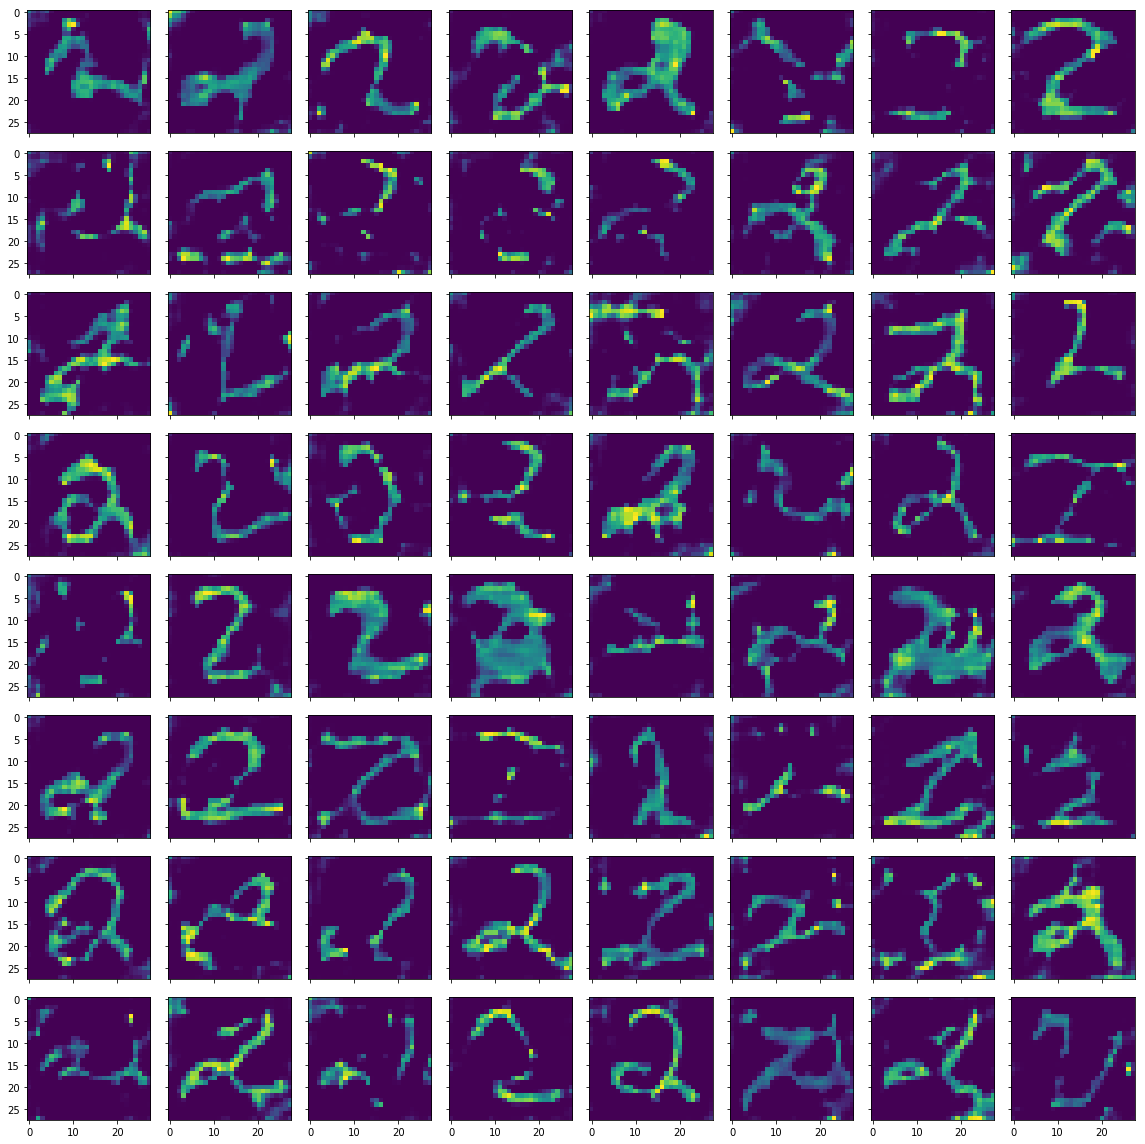

In [147]:
gan.show(shape=(8, 8))

In [136]:
noise = gan.make_noise()

gan.models.g.predict(noise)
(gan.models.a.predict(noise)).flatten()

array([0.38046598, 0.5970484 , 0.8015667 , 0.38762435, 0.555638  ,
       0.49294344, 0.33578062, 0.4822083 , 0.584681  , 0.61971015,
       0.38658938, 0.42868474, 0.54119253, 0.5016283 , 0.46551302,
       0.64283735, 0.4259398 , 0.57752174, 0.47662583, 0.47753084,
       0.542692  , 0.4859353 , 0.54146814, 0.47088113, 0.45933348,
       0.41408432, 0.4865292 , 0.40822706, 0.63068837, 0.35191983,
       0.37262744, 0.49819508, 0.7761039 , 0.51103103, 0.4378985 ,
       0.48875937, 0.39189306, 0.6231127 , 0.46390274, 0.591074  ,
       0.3503346 , 0.45801184, 0.5087277 , 0.53094006, 0.5681835 ,
       0.47371623, 0.40397397, 0.4385259 , 0.6341998 , 0.4231029 ,
       0.45815727, 0.3870038 , 0.68108064, 0.7411315 , 0.6044667 ,
       0.46901193, 0.6349043 , 0.42535034, 0.4746495 , 0.5368601 ,
       0.67616135, 0.46540102, 0.41210568, 0.43642393], dtype=float32)

In [138]:
def show(shape=(4, 4)):
    rows, cols = shape
#     x = np.expand_dims(X_train.copy(), axis=-1)
    x = X_train.copy()
    np.random.shuffle(x)
    x = x[0:BATCH_SIZE, :, :, :]
    image_noise, frac = gan.make_image_noise()
    x  += image_noise
    fig, axes_groups = plt.subplots(rows, cols, figsize=(2*rows, 2*cols), sharex=True, sharey=True)
    count = 0
    for i, axes in enumerate(axes_groups):
        for j, ax in enumerate(axes):
            img = x[count, :, :, :]
            img = img.reshape(28, 28)
            ax.imshow(img, cmap='gray')
            count += 1
    plt.tight_layout()

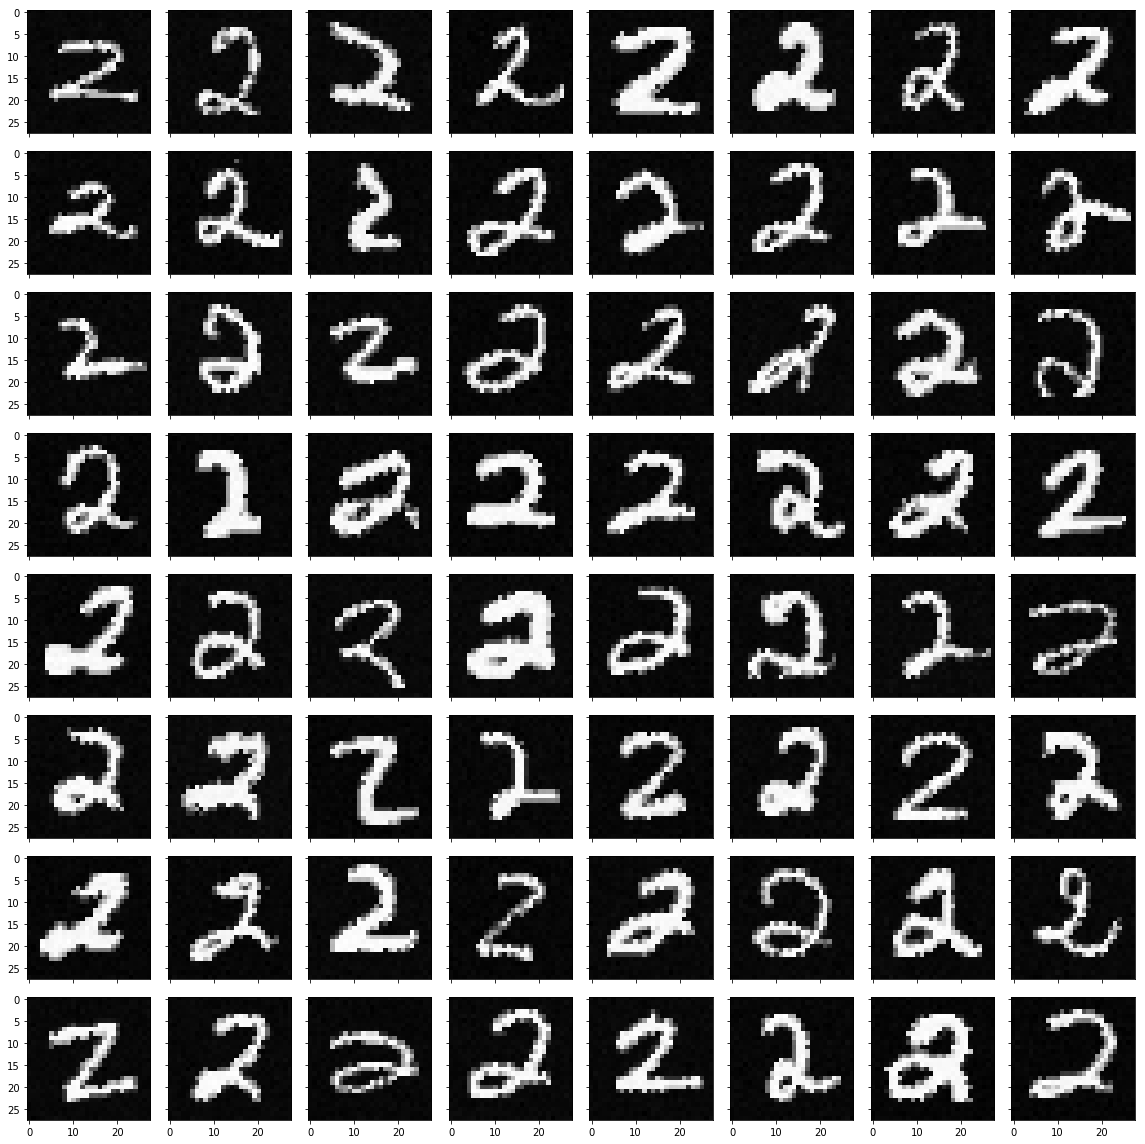

In [139]:
show(shape=(8, 8))

In [370]:
gan.save('../models')